In [1]:
import os
from IPython.display import Audio

import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import Audio
import skimage as sk

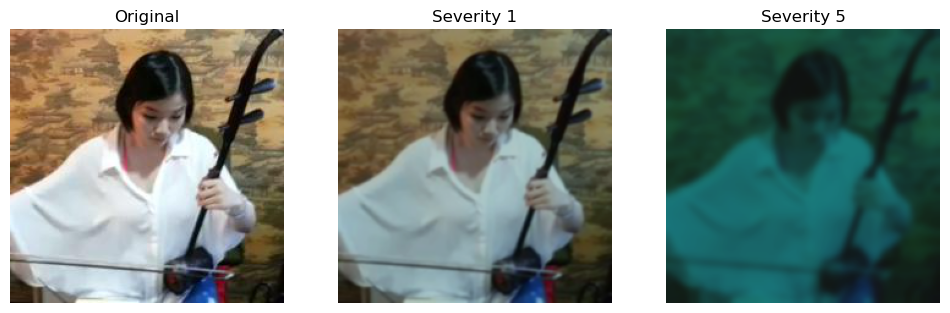

In [2]:
def gaussian_noise(x, severity=1):
    img = np.array(x)

    # Define intensity-based parameters
    blur_levels = {1: 3, 2: 5, 3: 7, 4: 10, 5: 15}  # Blur kernel size
    red_reduction = {1: 0.9, 2: 0.7, 3: 0.5, 4: 0.3, 5: 0.1}  # % of red channel kept
    contrast_factors = {1: 0.9, 2: 0.8, 3: 0.7, 4: 0.6, 5: 0.5}  # Contrast reduction
    haze_factors = {1: 20, 2: 40, 3: 60, 4: 80, 5: 100}  # White overlay intensity

    blur_k = blur_levels[severity]
    red_factor = red_reduction[severity]
    contrast = contrast_factors[severity]
    haze_intensity = haze_factors[severity]

    # Reduce red channel to simulate underwater color shift
    img_underwater = img.astype(np.float32)
    img_underwater[:, :, 0] *= red_factor  # Reduce red
    img_underwater = np.clip(img_underwater, 0, 255).astype(np.uint8)
    img_blurred = cv2.GaussianBlur(img_underwater, (blur_k, blur_k), 0)
    img_low_contrast = cv2.convertScaleAbs(img_blurred, alpha=contrast, beta=0)
    haze = np.full_like(img_low_contrast, (haze_intensity, haze_intensity, haze_intensity), dtype=np.uint8)
    img_hazy = cv2.addWeighted(img_low_contrast, 0.85, haze, 0.15, 0)

    return  img_hazy

# Load the image
image_path = "/people/cs/s/skm200005/UTD/audio-visual-datasets/VGGSound/test/image_mulframe_test/frame_0/__2MwJ2uHu0_4.jpg"  # Change this to your image path
original = cv2.imread(image_path)  # Load using OpenCV
original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

# Apply Gaussian noise at severity 1 and 5
image_severity_1 = gaussian_noise(original, severity=1).astype(np.uint8)
image_severity_5 = gaussian_noise(original, severity=5).astype(np.uint8)

# Display the images
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(original)
axes[0].set_title("Original")
axes[1].imshow(image_severity_1)
axes[1].set_title("Severity 1")
axes[2].imshow(image_severity_5)
axes[2].set_title("Severity 5")

for ax in axes:
    ax.axis("off")

plt.show()

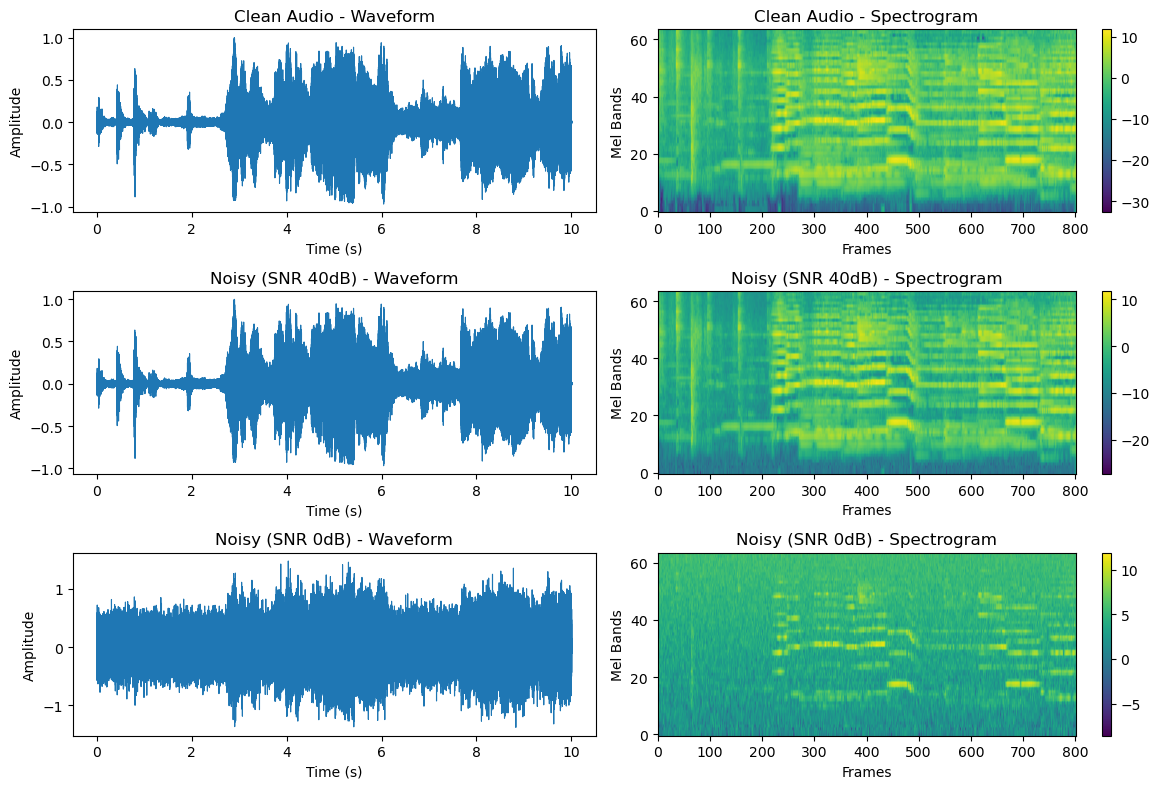

In [4]:
import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
import random

NOISE_SNRS = [40, 30, 20, 10, 0]  # SNR levels for different noise intensities

def add_noise(
    waveform: torch.Tensor, noise: torch.Tensor, snr: torch.Tensor, lengths = None
) -> torch.Tensor:
    
    if not (waveform.ndim - 1 == noise.ndim - 1 == snr.ndim and (lengths is None or lengths.ndim == snr.ndim)):
        raise ValueError("Input leading dimensions don't match.")

    L = waveform.size(-1)

    if L != noise.size(-1):
        raise ValueError(f"Length dimensions of waveform and noise don't match (got {L} and {noise.size(-1)}).")

    # compute scale
    if lengths is not None:
        mask = torch.arange(0, L, device=lengths.device).expand(waveform.shape) < lengths.unsqueeze(
            -1
        )  # (*, L) < (*, 1) = (*, L)
        masked_waveform = waveform * mask
        masked_noise = noise * mask
    else:
        masked_waveform = waveform
        masked_noise = noise

    energy_signal = torch.linalg.vector_norm(masked_waveform, ord=2, dim=-1) ** 2  # (*,)
    energy_noise = torch.linalg.vector_norm(masked_noise, ord=2, dim=-1) ** 2  # (*,)
    original_snr_db = 10 * (torch.log10(energy_signal) - torch.log10(energy_noise))
    scale = 10 ** ((original_snr_db - snr) / 20.0)  # (*,)

    # scale noise
    scaled_noise = scale.unsqueeze(-1) * noise  # (*, 1) * (*, L) = (*, L)

    return waveform + scaled_noise  # (*, L)


def add_gaussian_noise(audio_file, intensity):    
    def add_gaussian_noise(waveform, snr_db):
        noise = torch.randn_like(waveform)  # Generate Gaussian noise
        snr_tensor = torch.tensor([snr_db], dtype=waveform.dtype, device=waveform.device).expand(waveform.shape[:-1])  
        return add_noise(waveform, noise, snr_tensor)  # Corrected SNR shape
    waveform, sr = torchaudio.load(audio_file)
    waveform_noise = add_gaussian_noise(waveform, NOISE_SNRS[intensity-1])
    return waveform_noise

    

def plot_waveform_and_spectrogram(waveform, sr, title, ax1, ax2):
    """
    Plots the waveform and spectrogram of an audio signal.
    """
    ax1.plot(torch.arange(waveform.shape[1]) / sr, waveform.numpy().squeeze(), linewidth=0.8)
    ax1.set_title(f"{title} - Waveform")
    ax1.set_xlabel("Time (s)")
    ax1.set_ylabel("Amplitude")

    transform = T.MelSpectrogram(sample_rate=sr, n_mels=64)
    mel_spec = transform(waveform)

    im = ax2.imshow(mel_spec.log2().numpy().squeeze(), aspect='auto', origin='lower')
    ax2.set_title(f"{title} - Spectrogram")
    ax2.set_xlabel("Frames")
    ax2.set_ylabel("Mel Bands")
    plt.colorbar(im, ax=ax2)

# Load audio file
audio_path = "/people/cs/s/skm200005/UTD/audio-visual-datasets/VGGSound/test/audio_test/__2MwJ2uHu0_4.wav"  # Change this to your actual audio file path
waveform, sr = torchaudio.load(audio_path)

# Generate noisy versions
waveform_noise_1 = add_gaussian_noise(audio_path, 1)  # Least noise (SNR = 40dB)
waveform_noise_5 = add_gaussian_noise(audio_path, 5)  # Most noise (SNR = 0dB)

# Plot waveforms and spectrograms
fig, axes = plt.subplots(3, 2, figsize=(12, 8))

plot_waveform_and_spectrogram(waveform, sr, "Clean Audio", axes[0, 0], axes[0, 1])
plot_waveform_and_spectrogram(waveform_noise_1, sr, "Noisy (SNR 40dB)", axes[1, 0], axes[1, 1])
plot_waveform_and_spectrogram(waveform_noise_5, sr, "Noisy (SNR 0dB)", axes[2, 0], axes[2, 1])

plt.tight_layout()
plt.show()


In [35]:
Audio(waveform_noise_5, rate=sr)